In [103]:
import numpy as np
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from matplotlib import rcParams


plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 18})

In [3]:
L = 10 # define domain
x2 = np.arange(-L,L,0.1) 
n = len(x2)
k = n*(2*np.pi/(2*L))*np.fft.fftfreq(n) # k-vector
ye = np.exp(-np.power(x2,2))
ye2 = np.exp(np.power(x2,2)/2) # define Gaussians

y = np.zeros((n,10))

for jj in range(10): # loop through 10 modes
    # 2nd derivative
    yd = np.real(np.fft.ifft((np.power((1j)*k,jj))*np.fft.fft(ye)))
    
    mode = np.power(-1,jj) * \
        np.power((np.power(2,jj)*np.math.factorial(jj)*np.sqrt(np.pi)),-0.5) * \
        ye2 * yd
            
    y[:,jj] = mode # store modes as columns
            
x = x2[int(n/2)-40 : int(n/2)+41] # keep only -4<x<4
yharm = y[int(n/2)-40 : int(n/2)+41,:]

In [25]:
n = len(x)
f = np.exp(-np.power(x-0.5,2)) + 3*np.exp(-2*np.power(x+1.5,2))

a = np.zeros(10)

for jj in range(10):
    a[jj] = np.trapz(f*yharm[:,jj],x)

f2 = yharm @ a
Efull = np.linalg.norm(f2-f) # recontruction error
    
M = np.zeros((10,10))

for jj in range(10): # matrix M reconstruction
    for kk in range(jj+1):
        Area = np.trapz(yharm[:,jj]*yharm[:,kk],x)
        M[jj,kk] = Area
        M[kk,jj] = Area

Cfull = np.linalg.cond(M) # get condition number

In [27]:
## Test Random trials with P% of measurements

# matrices for mean and variance of error and conditioning numbers
E = np.zeros(5)
Ec = np.zeros(5)
V = np.zeros(5)
Vc = np.zeros(5)

for thresh in range(5):
    Err = np.zeros(1000)
    con = np.zeros(1000)
    for jloop in range(1000): # 1000 random trials
        n2 = np.random.choice(n,size=8*(thresh+1)) # random sampling
        P = np.zeros(n)
        P[n2] = 1
        
        # compute M matrix
        M2 = np.zeros((10,10))
        for jj in range(10):
            for kk in range(jj+1):
                Area = np.trapz(P*yharm[:,jj]*yharm[:,kk],x)
                M2[jj,kk] = Area
                M2[kk,jj] = Area
        
        ftild = np.zeros(10)
        for jj in range(10): # reconstruction using gappy
            ftild[jj] = np.trapz(P*f*yharm[:,jj],x)

        atild = np.linalg.solve(M2,ftild) # compute error
        f2 = yharm @ atild                # compute reconstruction
        Err[jloop] = np.linalg.norm(f2-f) # L2 error
        con[jloop] = np.linalg.cond(M2)   # condition number
        
    # mean and variance
    E[thresh] = np.mean(np.log(Err+1))
    V[thresh] = np.var(np.log(Err+1))
    Ec[thresh] = np.mean(np.log(con))
    Vc[thresh] = np.var(np.log(con))
    
E = np.concatenate((E,[Efull]))
V = np.concatenate((V,[0]))
Ec = np.concatenate((Ec,[Cfull]))
Vc = np.concatenate((Vc,[0]))

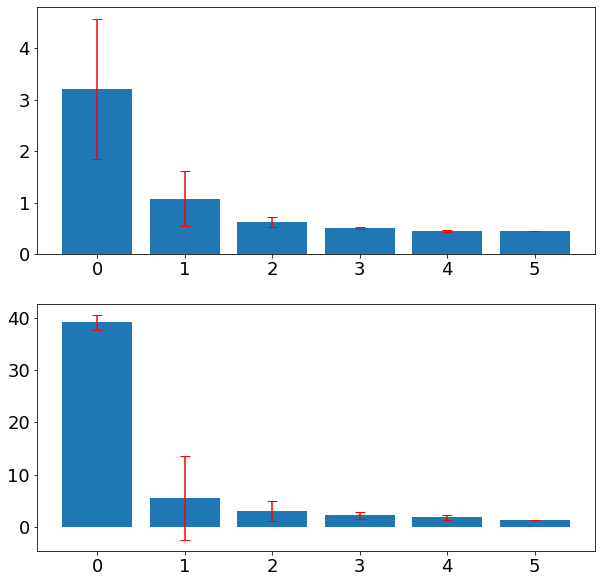

In [30]:
fig,axs = plt.subplots(2,1)
axs[0].bar(range(len(E)),E,yerr=V,ecolor='r',capsize=5)
axs[1].bar(range(len(Ec)),Ec,yerr=Vc,ecolor='r',capsize=5)

plt.show()

In [42]:
## For 20% measurements, sort great from bad
Pmaster = np.zeros((n,200))
Er = np.zeros(200)
co = np.zeros(200)
for jloop in range(200): # 200 random trials
    n2 = np.random.choice(n,20) # random sampling
    P = np.zeros(n)
    P[n2] = 1
    Pmaster[:,jloop] = P

    # compute M matrix
    M2 = np.zeros((10,10))
    for jj in range(10):
        for kk in range(jj+1):
            Area = np.trapz(P*yharm[:,jj]*yharm[:,kk],x)
            M2[jj,kk] = Area
            M2[kk,jj] = Area

    ftild = np.zeros(10)
    for jj in range(10): # reconstruction using gappy
        ftild[jj] = np.trapz(P*f*yharm[:,jj],x)

    atild = np.linalg.solve(M2,ftild) # compute error
    f2 = yharm @ atild                # compute reconstruction
    Er[jloop] = np.linalg.norm(f2-f) # L2 error
    co[jloop] = np.linalg.cond(M2)   # condition number

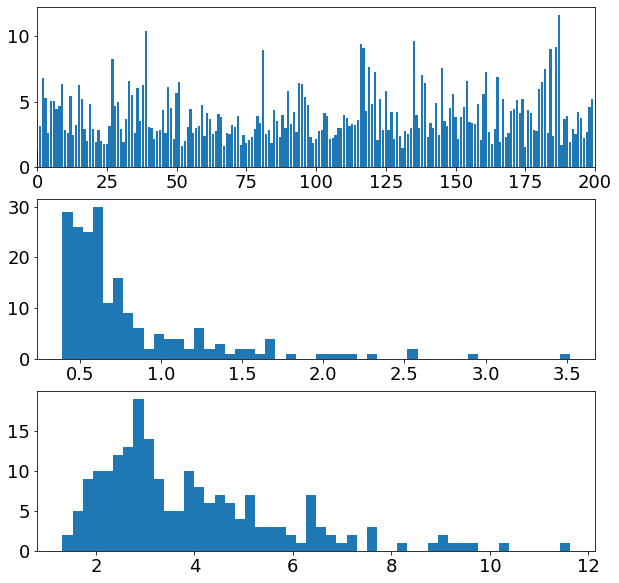

In [39]:
fig,axs = plt.subplots(3,1)
axs[0].bar(range(len(co)),np.log(co))
axs[0].set_xlim(0,len(co))
axs[1].hist(np.log(Er+1),50)
axs[2].hist(np.log(co),50)

plt.show()

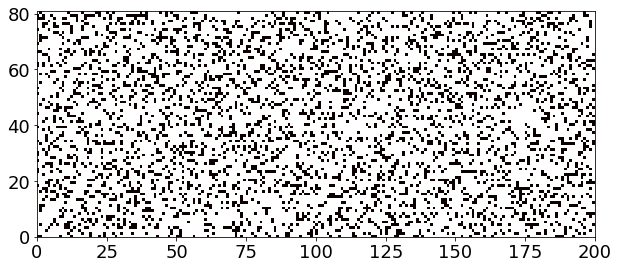

In [51]:
fig, ax = plt.subplots(1,1)
ax.pcolor(-Pmaster,cmap='hot')
ax.set_aspect('equal', 'box')

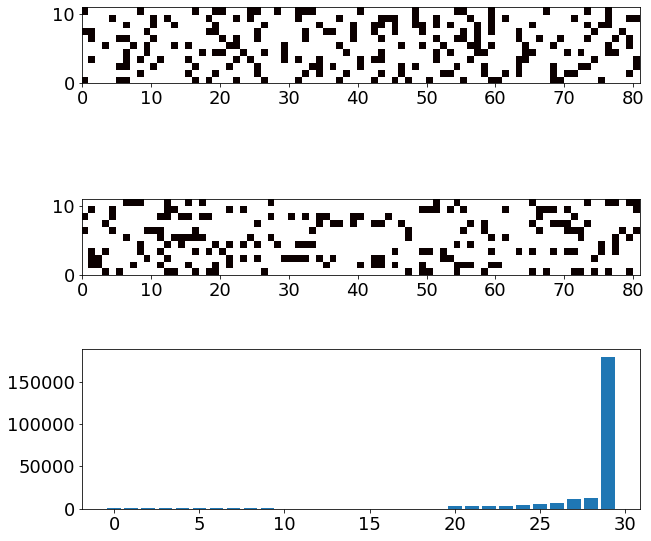

In [101]:
jloc = np.argsort(co)
Cloc = co[jloc]

jbest = jloc[:11]
jworst = jloc[-11:]
Sbest = Pmaster[:,jbest]
Sworst = Pmaster[:,jworst]
csor = np.concatenate((100*Cloc[:10],np.zeros(10),Cloc[-10:]))
# Note that the values for the 10 best are inflated 100-fold 
# for plotting visibility

fig,axs = plt.subplots(3,1)
axs[0].pcolor(-Sbest.T,cmap='hot')
axs[1].pcolor(-Sworst.T,cmap='hot')
axs[2].bar(range(len(csor)),csor)

for ax in axs[:-1]:
    ax.set_aspect('equal', 'box')
plt.show()

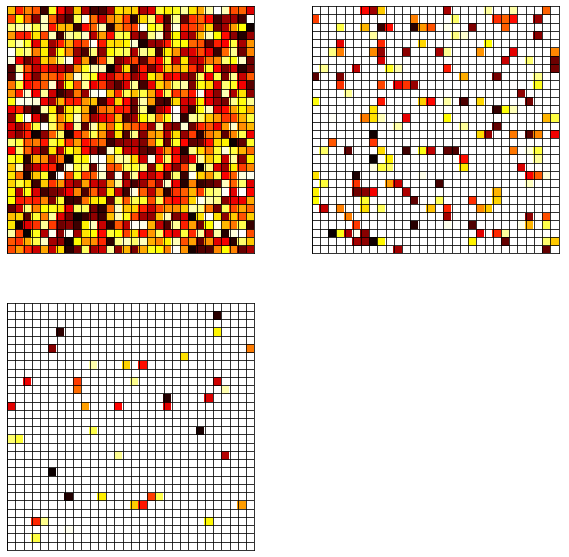

In [102]:
m = 30
q = np.random.rand(m,m)
q = q.reshape(-1)
n = m**2
p = np.random.choice(n,200)
q2 = np.zeros(n)
q2[p] = q[p]
p2 = np.random.choice(n,40)
q3 = np.zeros(n)
q3[p2] = q[p2]
q = q.reshape((m,m))
q2 = q2.reshape((m,m))
q3 = q3.reshape((m,m))

fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)
axs[0].pcolormesh(-q,cmap='hot')
axs[1].pcolormesh(-q2,cmap='hot')
axs[2].pcolor(-q3,cmap='hot')

for ax in axs[:-1]:
    ax.set_aspect('equal', 'box')
    ax.minorticks_off()
    ax.grid(True, which='major', axis='both', linestyle='-', color='k')
    ax.set_xticks(range(m), minor=False)
    ax.set_yticks(range(m), minor=False)
    ax.tick_params(bottom=False,left=False)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_xlim(0,m)
    ax.set_ylim(0,m)

axs[-1].axis(False)
plt.show()